In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import pandas as pd
import sys

sys.path.append("../")

In [50]:
from src.epl_player_data_utils import EPLPlayerData

epl_player_data = EPLPlayerData("../SampleData/players.json")
epl_player_data

EPLPlayerData(../SampleData/players.json): 804 players

In [106]:
shots_dataset = pd.read_csv("shots_dataset.csv").drop(columns=["lineup_id"])
shots_dataset

,player_id,team_id,match_id,match_num,shots_ratio
0,0.0,0,441999,0,0.000000
1,0.0,0,441999,0,0.000000
2,17733.0,0,441999,0,0.032249
3,19524.0,0,441999,0,0.016125
4,15943.0,0,441999,0,0.016125
...,...,...,...,...,...
41920,76227.0,1,442378,379,0.000000
41921,50471.0,1,442378,379,0.000000
41922,125510.0,1,442378,379,0.000000
41923,0.0,1,442378,379,0.000000


In [107]:
# Scale shots_ratio using LogNormal

from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler

# power_transformer = StandardScaler()s
# shots_dataset["shots_ratio"] = power_transformer.fit_transform(shots_dataset[["shots_ratio"]])

In [108]:
players = shots_dataset["player_id"].unique().astype(int)
player_pos = {player: epl_player_data.get_player_position(player) for player in players}

shots_dataset["player_position"] = shots_dataset["player_id"].apply(lambda x: player_pos[x])
shots_dataset

,player_id,team_id,match_id,match_num,shots_ratio,player_position
0,0.0,0,441999,0,0.000000,None
1,0.0,0,441999,0,0.000000,None
2,17733.0,0,441999,0,0.032249,F
3,19524.0,0,441999,0,0.016125,M
4,15943.0,0,441999,0,0.016125,D
...,...,...,...,...,...,...
41920,76227.0,1,442378,379,0.000000,M
41921,50471.0,1,442378,379,0.000000,M
41922,125510.0,1,442378,379,0.000000,F
41923,0.0,1,442378,379,0.000000,None


In [109]:
shots_dataset_non_zero = shots_dataset[shots_dataset["shots_ratio"] > 0]
shots_dataset_non_zero

,player_id,team_id,match_id,match_num,shots_ratio,player_position
2,17733.0,0,441999,0,0.032249,F
3,19524.0,0,441999,0,0.016125,M
4,15943.0,0,441999,0,0.016125,D
5,20467.0,0,441999,0,0.016125,F
9,17127.0,0,441999,0,0.032249,D
...,...,...,...,...,...,...
41867,3296.0,1,442378,379,0.014918,D
41868,50023.0,1,442378,379,0.014918,M
41869,74235.0,1,442378,379,0.014918,D
41871,50471.0,1,442378,379,0.029836,M


<Axes: xlabel='player_position'>

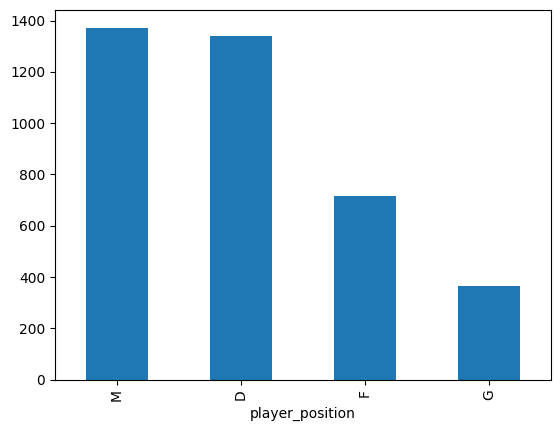

In [110]:
shots_dataset_non_zero["player_position"].value_counts().plot(kind="bar")

In [111]:
shots_dataset_enc = pd.get_dummies(shots_dataset_non_zero, columns=["player_position"])
shots_dataset_enc

,player_id,team_id,match_id,match_num,shots_ratio,player_position_D,player_position_F,player_position_G,player_position_M
2,17733.0,0,441999,0,0.032249,False,True,False,False
3,19524.0,0,441999,0,0.016125,False,False,False,True
4,15943.0,0,441999,0,0.016125,True,False,False,False
5,20467.0,0,441999,0,0.016125,False,True,False,False
9,17127.0,0,441999,0,0.032249,True,False,False,False
...,...,...,...,...,...,...,...,...,...
41867,3296.0,1,442378,379,0.014918,True,False,False,False
41868,50023.0,1,442378,379,0.014918,False,False,False,True
41869,74235.0,1,442378,379,0.014918,True,False,False,False
41871,50471.0,1,442378,379,0.029836,False,False,False,True


In [112]:
# Last 111 Match IDs are test set
train_set = shots_dataset_enc[shots_dataset_enc["match_num"] <= 379 - 111]
test_set = shots_dataset_enc[shots_dataset_enc["match_num"] > 379 - 111]

train_set["match_num"].unique().shape, test_set["match_num"].unique().shape

((269,), (111,))

In [113]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np

Train MSE: 0.004421086713284054, Test MSE: 0.002342688228721867


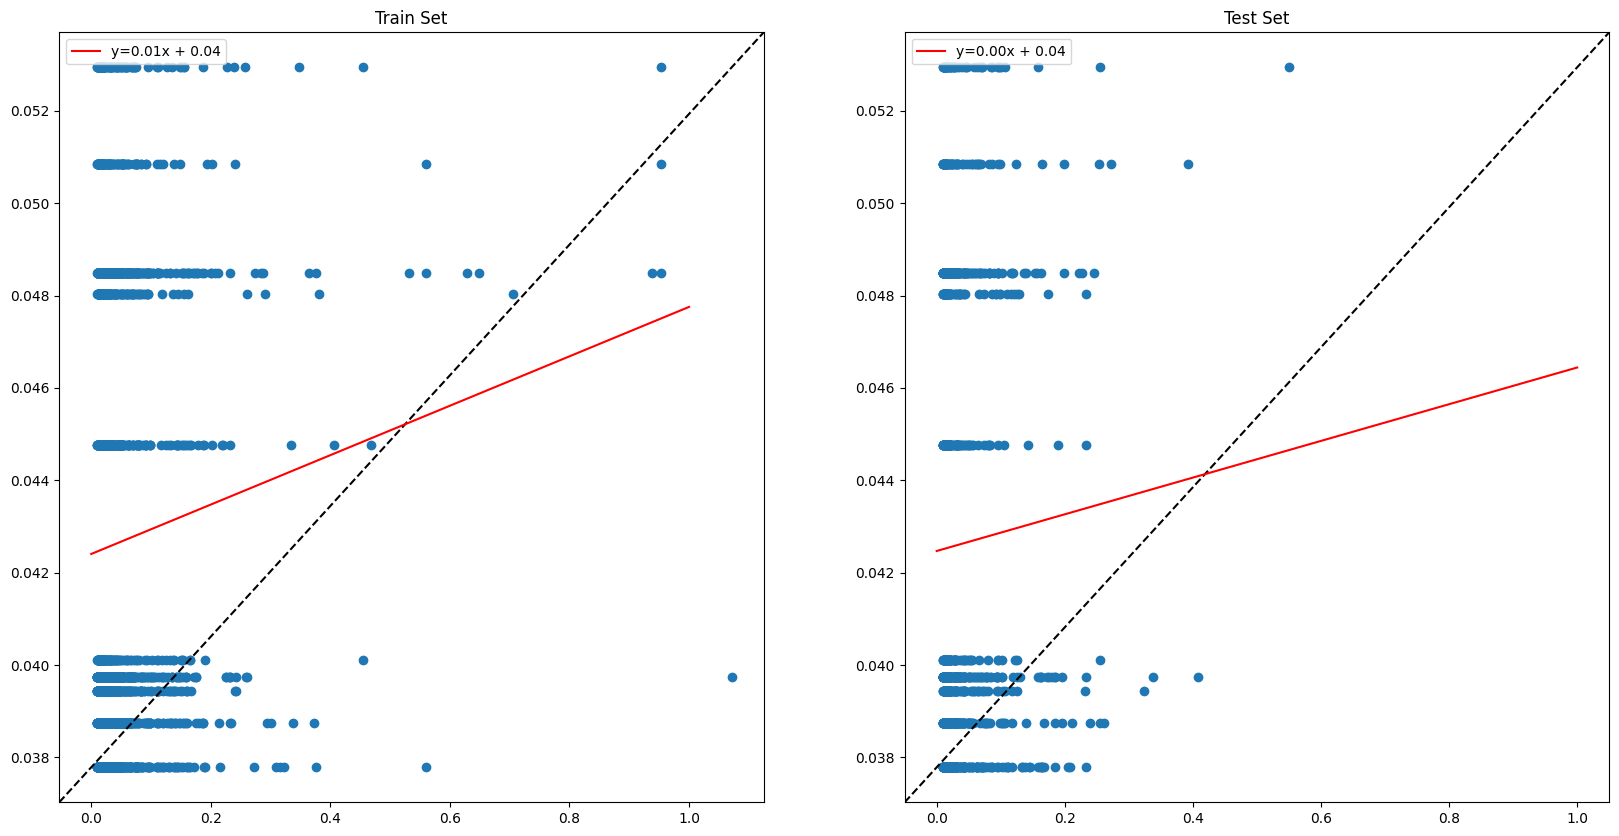

In [114]:
def fit_xgb_model(train_set, target_column, drop_columns):
    model = xgb.XGBRegressor(objective="reg:squarederror")
    model.fit(train_set.drop(columns=drop_columns), train_set[target_column])
    return model


def predict_and_evaluate(model, data_set, target_column, drop_columns):
    preds = model.predict(data_set.drop(columns=drop_columns))
    mse = mean_squared_error(data_set[target_column], preds)
    return preds, mse


def plot_scatter_with_regression(ax, x, y, title):
    ax.scatter(x, y)
    ax.set_title(title)
    # Plot y=x line
    ax.plot([0, 1], [0, 1],
        transform=ax.transAxes, 
        linestyle="--", color="black"
    )
    # Plot regression line using linear regression
    lr_model = LinearRegression()
    lr_model.fit(x.values.reshape(-1, 1), y)
    x_line = np.linspace(0, 1, 100)
    slope = lr_model.coef_[0]
    intercept = lr_model.intercept_
    ax.plot(
        x_line,
        lr_model.predict(x_line.reshape(-1, 1)),
        color="red",
        label=f"y={slope:.2f}x + {intercept:.2f}",
    )
    ax.legend()


# Datos de entrada
target_column = "shots_ratio"
drop_columns = ["shots_ratio", "match_id", "player_id", "match_num"]

# Ajustar el modelo XGBoost
xgb_model = fit_xgb_model(train_set, target_column, drop_columns)

# Predecir y evaluar el modelo
train_preds, train_mse = predict_and_evaluate(
    xgb_model, train_set, target_column, drop_columns
)
test_preds, test_mse = predict_and_evaluate(
    xgb_model, test_set, target_column, drop_columns
)

# Mostrar MSE
print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

# Graficar los resultados
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_scatter_with_regression(ax[0], train_set[target_column], train_preds, "Train Set")
plot_scatter_with_regression(ax[1], test_set[target_column], test_preds, "Test Set")

plt.show()

Train MSE: 0.004426178311705898, Test MSE: 0.0023298316175847746


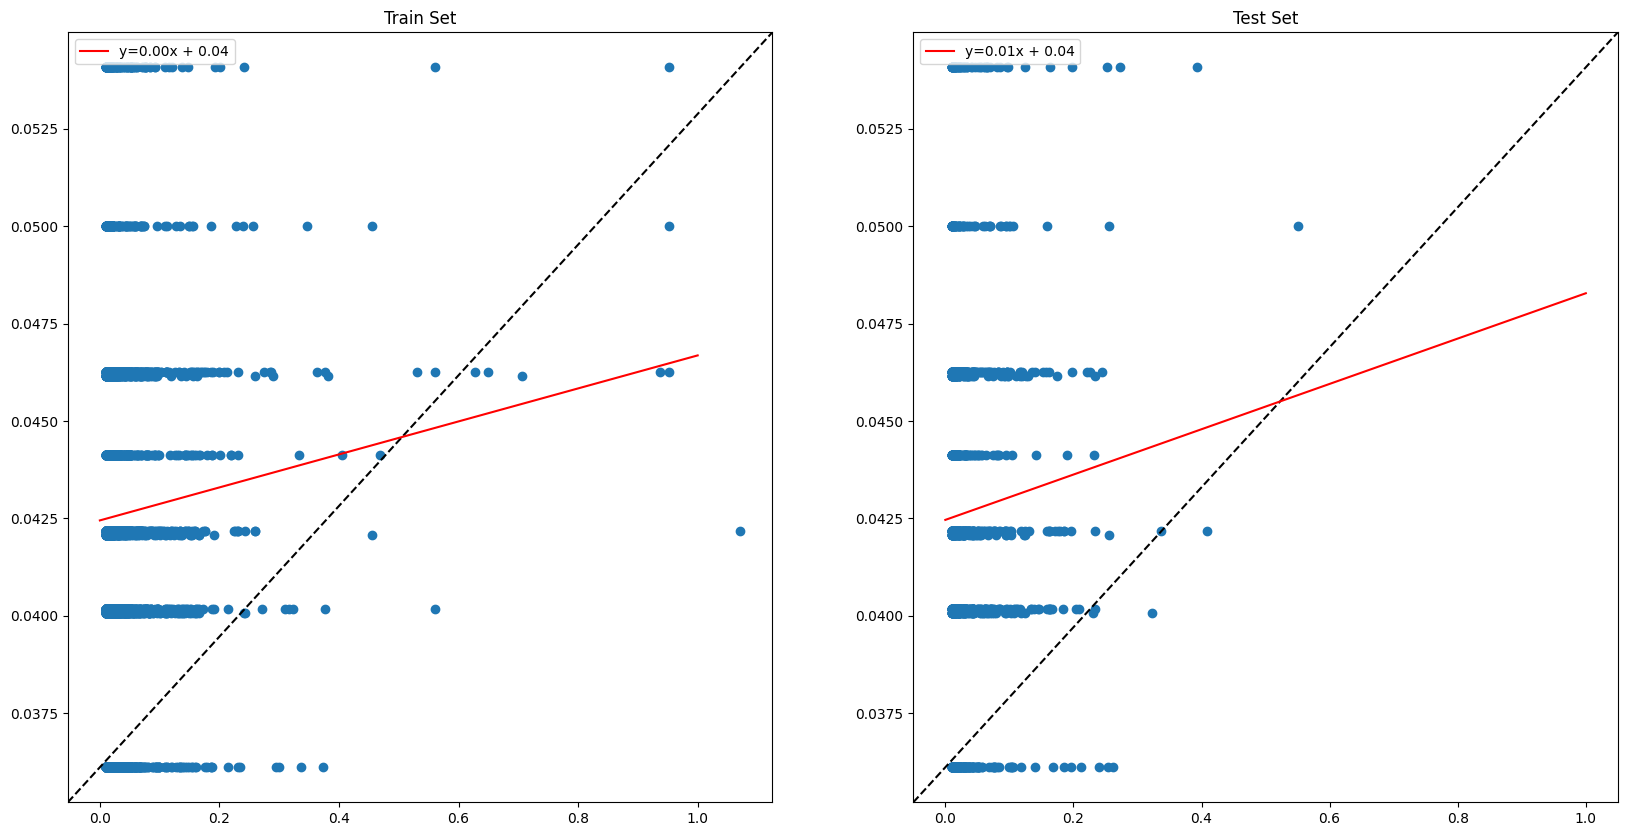

In [115]:
lr_model = LinearRegression()
lr_model.fit(train_set.drop(columns=drop_columns), train_set[target_column])

train_preds, train_mse = predict_and_evaluate(
    lr_model, train_set, target_column, drop_columns
)
test_preds, test_mse = predict_and_evaluate(
    lr_model, test_set, target_column, drop_columns
)

print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_scatter_with_regression(ax[0], train_set[target_column], train_preds, "Train Set")
plot_scatter_with_regression(ax[1], test_set[target_column], test_preds, "Test Set")

plt.show()

Text(0.5, 1.0, 'Linear Regression Model')

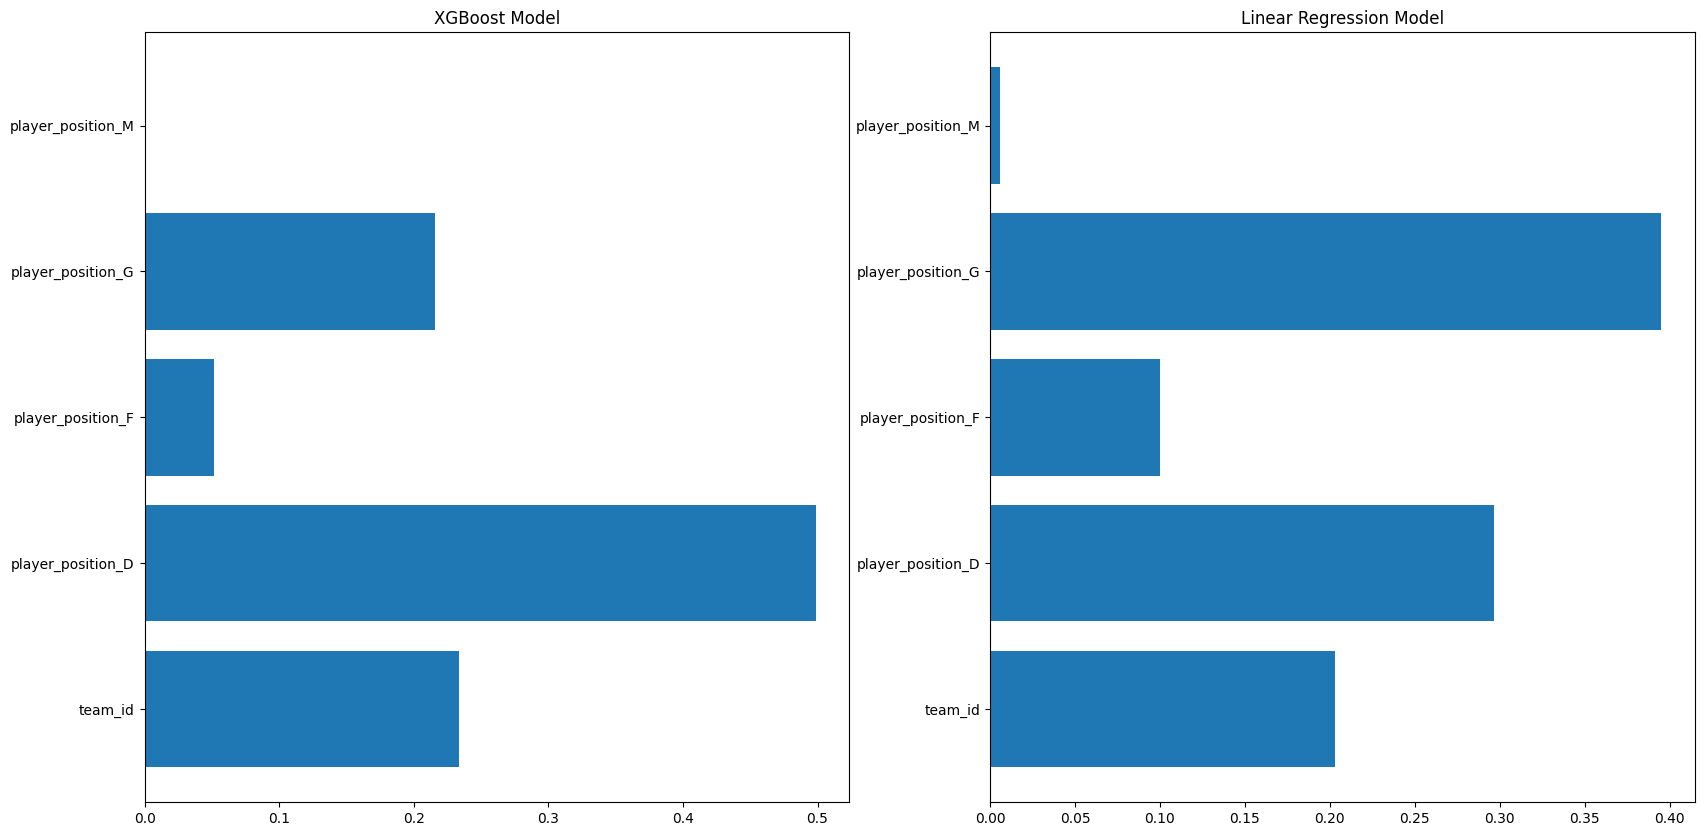

In [116]:
# Feature importance
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

xgb_importance = xgb_model.feature_importances_
xgb_importance /= xgb_importance.sum()
ax[0].barh(train_set.drop(columns=drop_columns).columns, xgb_importance)
ax[0].set_title("XGBoost Model")

lr_importance = np.abs(lr_model.coef_)
lr_importance /= lr_importance.sum()
ax[1].barh(train_set.drop(columns=drop_columns).columns, lr_importance)
ax[1].set_title("Linear Regression Model")

In [117]:
def load_player_features_dataframe(filepath):
    # Load the DataFrame from disk
    return pd.read_parquet(filepath)


def get_features_from_df(player_id, match_id, features_df, cols):
    return features_df.loc[(player_id, match_id)][cols].to_dict()
    # try:
    # except KeyError:
    #     return {col: 0 for col in cols}


player_features_df = load_player_features_dataframe("player_features_optimized.parquet")

In [118]:
list(player_features_df.iloc[0].index)

['pases/90', 'shots/90', 'losses/90', 'gains/90', 'minutes', 'match_date']

In [119]:
# # DataLeakage Features

# player_features = {}

# # For each player in player_features_df, get last match by date in which player played
# # and get the features for that match divided the total minutes played by the player ("minutes")

# for player_id in player_features_df.index.get_level_values(0).unique():

#     last = player_features_df.loc[player_id].sort_values("match_date").iloc[-1]
#     # Drop match_date
#     # last = last.drop("match_date")
#     if last["minutes"] != 0:
#         for col in last.index:
#             if col != "match_date":
#                 last[col] = last[col] / last["minutes"]

#     player_features[player_id] = last.to_dict()

# ds_w_features = shots_dataset_enc.copy()

# # Add player features to dataset
# for col in player_features_df.columns:
#     ds_w_features[col] = ds_w_features.apply(
#         lambda x: player_features.get(x["player_id"]).get(col), axis=1
#     )

# ds_w_features

In [120]:
# # Copiar el DataFrame original
ds_w_features = shots_dataset_enc.copy()

# Aplicar la función y expandir el diccionario en nuevas columnas
feature_cols = []

for row in ds_w_features.itertuples():
    player_id = row.player_id
    match_id = row.match_id
    features = get_features_from_df(
        player_id,
        match_id,
        player_features_df,
        ["pases/90", "shots/90", "losses/90", "gains/90", "minutes", "match_date"],
    )
    for col, value in features.items():
        ds_w_features.at[row.Index, col] = value

# Verificar el resultado
ds_w_features.head()

,player_id,team_id,match_id,match_num,shots_ratio,player_position_D,player_position_F,player_position_G,player_position_M,pases/90,shots/90,losses/90,gains/90,minutes,match_date
2,17733.0,0,441999,0,0.032249,False,True,False,False,0.0,0.0,0.0,0.0,0.0,2012-08-18
3,19524.0,0,441999,0,0.016125,False,False,False,True,0.0,0.0,0.0,0.0,0.0,2012-08-18
4,15943.0,0,441999,0,0.016125,True,False,False,False,0.0,0.0,0.0,0.0,0.0,2012-08-18
5,20467.0,0,441999,0,0.016125,False,True,False,False,0.0,0.0,0.0,0.0,0.0,2012-08-18
9,17127.0,0,441999,0,0.032249,True,False,False,False,0.0,0.0,0.0,0.0,0.0,2012-08-18


In [121]:
# Model with player features

# Last 111 Match IDs are test set
f_train_set = ds_w_features[
    (ds_w_features["match_num"] <= 379 - 111) & (ds_w_features["match_num"] > 100)
]
f_test_set = ds_w_features[
    ds_w_features["match_num"] > 379 - 111
]

In [122]:
f_train_set

,player_id,team_id,match_id,match_num,shots_ratio,player_position_D,player_position_F,player_position_G,player_position_M,pases/90,shots/90,losses/90,gains/90,minutes,match_date
11394,63426.0,0,442100,101,0.038420,True,False,False,False,0.167131,0.000000,0.261335,0.261335,105.966667,2012-11-10
11395,80979.0,0,442100,101,0.025614,False,True,False,False,2.021762,0.175628,1.745563,1.003674,509.866667,2012-11-10
11440,27450.0,0,442100,101,0.010479,False,False,False,False,3.879610,0.065444,3.805043,3.498405,917.050000,2012-11-10
11447,55909.0,1,442100,101,0.042857,True,False,False,False,0.000000,0.000000,0.000000,0.000000,0.000000,2012-11-10
11448,13017.0,1,442100,101,0.021429,False,True,False,False,9.107923,0.421700,5.967537,3.840394,909.700000,2012-11-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29721,3332.0,1,442267,268,0.015617,True,False,False,False,6.734131,0.049342,5.859572,6.115986,1071.066667,2013-02-23
29732,14278.0,1,442267,268,0.056444,True,False,False,False,17.175995,0.000000,16.852476,17.709014,2962.816667,2013-02-23
29735,39253.0,1,442267,268,0.056444,True,False,False,False,14.902272,0.058867,17.943780,20.396428,3970.650000,2013-02-23
29737,3332.0,1,442267,268,0.112888,True,False,False,False,6.734131,0.049342,5.859572,6.115986,1071.066667,2013-02-23


In [123]:
# Feature Engineering

# Multiply  pases/90	shots/90	losses/90	gains/90 by minutes
f_train_set["pases"] = f_train_set["pases/90"] * f_train_set["minutes"]
f_train_set["shots"] = f_train_set["shots/90"] * f_train_set["minutes"]
f_train_set["losses"] = f_train_set["losses/90"] * f_train_set["minutes"]
f_train_set["gains"] = f_train_set["gains/90"] * f_train_set["minutes"]

f_test_set["pases"] = f_test_set["pases/90"] * f_test_set["minutes"]
f_test_set["shots"] = f_test_set["shots/90"] * f_test_set["minutes"]
f_test_set["losses"] = f_test_set["losses/90"] * f_test_set["minutes"]
f_test_set["gains"] = f_test_set["gains/90"] * f_test_set["minutes"]


/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_861/3531971444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_train_set["pases"] = f_train_set["pases/90"] * f_train_set["minutes"]
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_861/3531971444.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_train_set["shots"] = f_train_set["shots/90"] * f_train_set["minutes"]
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_861/3531971444.py:6: SettingWithCopyWarning: 
A value is 

Train MSE: 0.0004845216931486636, Test MSE: 0.0029676321509039816


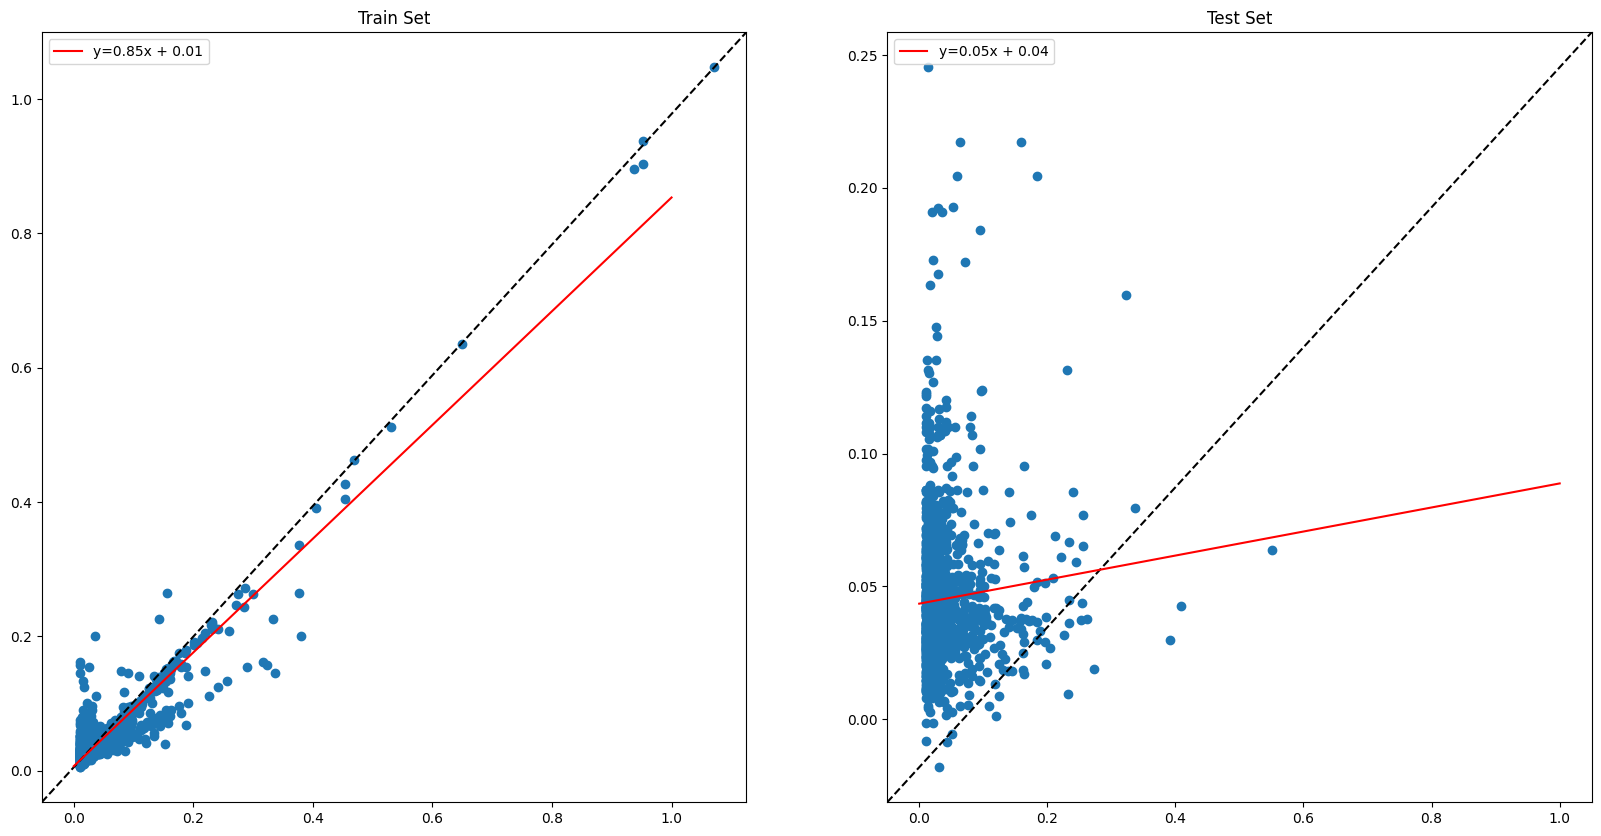

In [124]:
# Datos de entrada
target_column = "shots_ratio"
drop_columns = ["shots_ratio", "match_id", "player_id", "match_date", "match_num"]

# Ajustar el modelo XGBoost
xgb_model = fit_xgb_model(f_train_set, target_column, drop_columns)

# Predecir y evaluar el modelo
train_preds, train_mse = predict_and_evaluate(
    xgb_model, f_train_set, target_column, drop_columns
)
test_preds, test_mse = predict_and_evaluate(
    xgb_model, f_test_set, target_column, drop_columns
)

# Mostrar MSE
print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

# Graficar los resultados
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_scatter_with_regression(ax[0], f_train_set[target_column], train_preds, "Train Set")
plot_scatter_with_regression(ax[1], f_test_set[target_column], test_preds, "Test Set")

plt.show()


Train MSE: 0.004610487970436624, Test MSE: 0.0024825794663018174


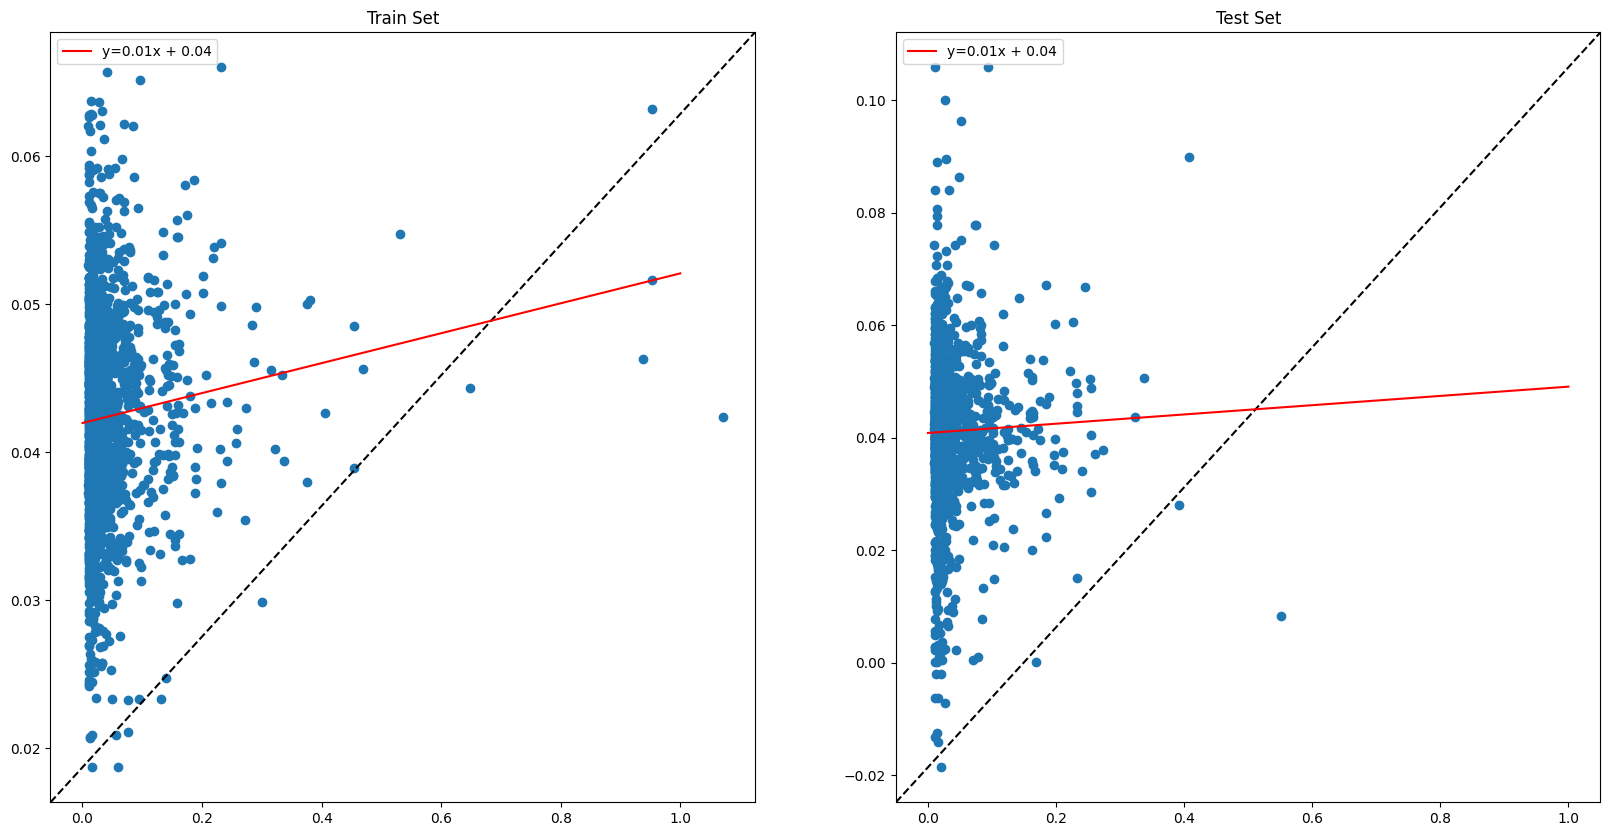

In [125]:
lr_model = LinearRegression()

lr_model.fit(f_train_set.drop(columns=drop_columns), f_train_set[target_column])

train_preds, train_mse = predict_and_evaluate(
    lr_model, f_train_set, target_column, drop_columns
)
test_preds, test_mse = predict_and_evaluate(
    lr_model, f_test_set, target_column, drop_columns
)

print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_scatter_with_regression(ax[0], f_train_set[target_column], train_preds, "Train Set")
plot_scatter_with_regression(ax[1], f_test_set[target_column], test_preds, "Test Set")

plt.show()

<BarContainer object of 14 artists>

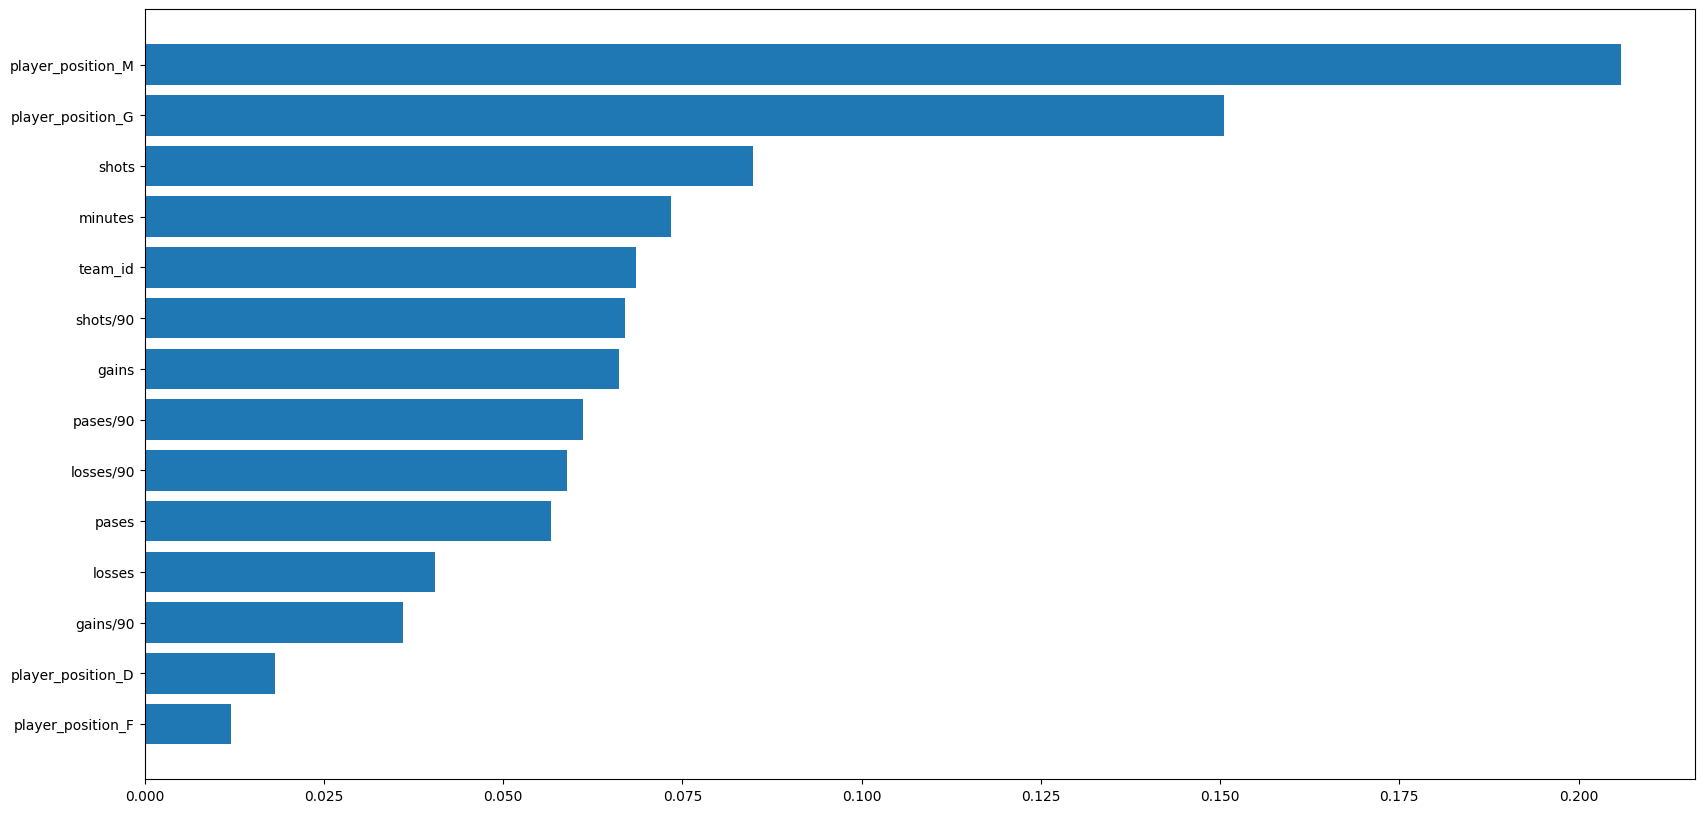

In [126]:
# Feature importance

fig, ax = plt.subplots(figsize=(20, 10))

xgb_importance = xgb_model.feature_importances_
xgb_importance /= xgb_importance.sum()

importances = pd.Series(xgb_importance, index=f_train_set.drop(columns=drop_columns).columns).sort_values(ascending=True)

ax.barh(importances.index, importances)
